In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Define dataset path from Google Drive
dataset_path = "/content/drive/MyDrive/GarbageClassificationDataset"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [15]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_data.class_indices.keys())

Found 3720 images belonging to 6 classes.
Found 930 images belonging to 6 classes.


In [16]:
# Build a lightweight CNN with dropout
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Reduces overfitting
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,974 (9.12 MB)

 Trainable params: 2,391,974 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

EPOCHS = 15
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.2852 - loss: 1.7059

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


117/117 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.2860 - loss: 1.7043 - val_accuracy: 0.4204 - val_loss: 1.4127
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.5061 - loss: 1.2514 - val_accuracy: 0.4333 - val_loss: 1.3836
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5726 - loss: 1.1224 - val_accuracy: 0.4774 - val_loss: 1.2773
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6239 - loss: 1.0006 - val_accuracy: 0.4710 - val_loss: 1.2635
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6365 - loss: 0.9879 - val_accuracy: 0.4882 - val_loss: 1.3108
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6585 - loss: 0.9242 - val_accuracy: 0.5280 - val_loss: 1.1621
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6894 - loss: 0.8564 - val_accuracy: 0.5258 - val_loss: 1.1757
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6811 - loss: 0.8682 - val_accuracy: 0.544

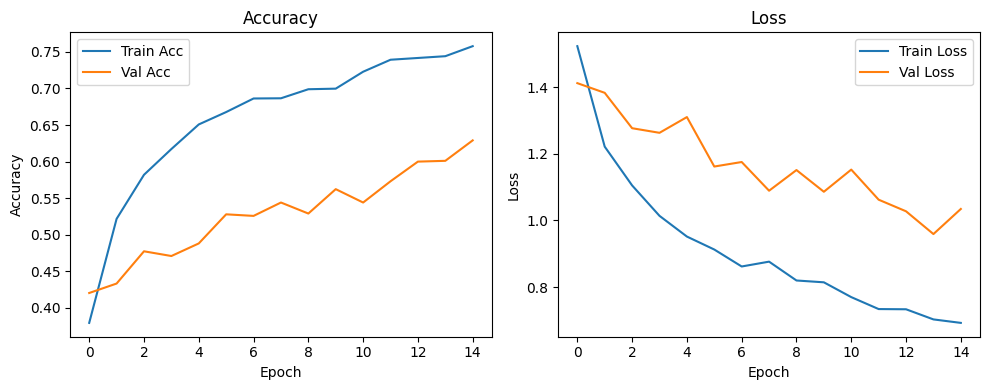

In [18]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Evaluate model
val_data.reset()
preds = model.predict(val_data)
pred_labels = np.argmax(preds, axis=1)
true_labels = val_data.classes

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step
Classification Report:
              precision    recall  f1-score   support

     battery       0.21      0.14      0.16       155
       glass       0.12      0.07      0.09       155
       metal       0.20      0.21      0.21       155
     organic       0.12      0.15      0.13       155
       paper       0.15      0.23      0.19       155
     plastic       0.21      0.19      0.20       155

    accuracy                           0.17       930
   macro avg       0.17      0.17      0.16       930
weighted avg       0.17      0.17      0.16       930

Confusion Matrix:
[[21 14 24 31 44 21]
 [ 8 11 26 41 45 24]
 [18 15 33 39 32 18]
 [24 11 29 23 40 28]
 [18 25 21 30 36 25]
 [12 18 30 29 36 30]]


In [20]:
# Convert model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to Drive
tflite_path = "/content/drive/MyDrive/garbage_classifier_6classes.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ TFLite model saved at: {tflite_path}")

Saved artifact at '/tmp/tmp70zm4o4b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136304412834320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412832208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412828176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412831632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412833168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412829520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412826256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412827600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412831440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136304412835088: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite mode

In [21]:
# Inference function using TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_image(image_path):
    img = Image.open(image_path).resize(IMG_SIZE)
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])[0]

    label_index = np.argmax(output)
    confidence = output[label_index]
    label = class_names[label_index]

    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    plt.imshow(img)
    plt.title(f"{label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

Prediction: plastic (Confidence: 0.61)


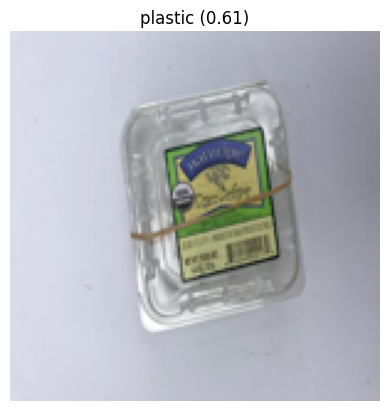

In [25]:
# Example usage (update with a real image path)
predict_image("/content/drive/MyDrive/GarbageClassificationDataset/plastic/plastic90.jpg")